[colab](https://colab.research.google.com/github/rufous86/studies/blob/main/DLS_NLP/05_language_modeling/hw_language_modelling.ipynb)

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы. 

В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [73]:
!pip install datasets -q

Импорт необходимых библиотек

In [74]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords

from collections import Counter
from typing import List

import string


import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams['lines.linewidth'] = 1

In [75]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [76]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [77]:
# Загрузим датасет
dataset = load_dataset('imdb')

  0%|          | 0/3 [00:00<?, ?it/s]

In [78]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать: 

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером. 
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```. 
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [79]:
sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences
for sentence in tqdm(dataset['train']['text']):
    sentences.extend(
        [x.lower() for x in sent_tokenize(sentence) if len(x) < word_threshold]
    )

  0%|          | 0/25000 [00:00<?, ?it/s]

In [80]:
print("Всего предложений:", len(sentences))

Всего предложений: 28827


Посчитаем для каждого слова его встречаемость.

In [81]:
def count_words(dataset, remove_stops=False):
    words = Counter()
    if remove_stops:
        stops = stopwords.words('english')
    else:
        stops = []

    # Расчет встречаемости слов
    for example in tqdm(dataset):
        # Приводим к нижнему регистру и убираем пунктуацию
        processed_text = example.lower().translate(
            str.maketrans('', '', string.punctuation))
        processed_text = [
            word for word in word_tokenize(processed_text)
                        # if word not in stops
                            # and len(word) > 1
        ]

        for word in processed_text:
            words[word] += 1
    return words

words = count_words(dataset['train']['text'], remove_stops=False)

  0%|          | 0/25000 [00:00<?, ?it/s]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [82]:
vocab_size = 40000

vocab = set(dict(sorted(words.items(), key=lambda x: x[1], reverse=True)[:vocab_size]).keys())
for serv_word in ['<unk>', '<bos>', '<eos>', '<pad>']:
    vocab.add(serv_word)

In [83]:
assert '<unk>' in vocab
assert '<bos>' in vocab 
assert '<eos>' in vocab 
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [84]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов). 

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```. 

In [85]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [86]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        # Допишите код здесь
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in self.data[idx].split(' ')]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [87]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)
    
    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [88]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве. 

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации. 
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве. 

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [89]:
def evaluate(model, criterion, dataloader) -> tuple[float, float]:
    model.eval()
    perplexity = []
    losses = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f'Validation'):
            logits = model(batch['input_ids'].flatten(start_dim=0, end_dim=1)) # Посчитайте логиты предсказаний следующих слов
            loss = criterion(logits, batch['target_ids'].flatten()).cpu().detach()
            perplexity.append(torch.exp(loss).item())
            losses.append(loss)
    
    perplexity = sum(perplexity) / len(perplexity)
    loss = sum(losses) / len(losses)

    return perplexity, loss.item()

### Train loop (1 балл)

Напишите функцию для обучения модели. 

In [90]:
def train_model(model, 
                train_dataloader, 
                val_dataloader, 
                criterion, 
                optimizer, 
                num_epoch = 10) -> dict:
    # Напишите код здесь
    losses = []
    perplexities = []
    val_losses = []
    val_perplexities = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'].flatten(start_dim=0, end_dim=1))
            loss = criterion(
                logits, batch['target_ids'].flatten())
            
            perplexity = torch.exp(loss).item()
            perplexities.append(perplexity)
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
        print('train_loss:', losses[-1])
        print('train_perplexity:', perplexities[-1])
            
        val_perplexity, val_loss = evaluate(model, criterion, val_dataloader)
        val_losses.append(val_loss)
        val_perplexities.append(val_perplexity)
        
        print('val_loss:', val_losses[-1])
        print('val_perplexity:', val_perplexities[-1])

    history = {
        'train_loss': losses,
        'train_perplexity': perplexities,
        'val_loss': val_losses,
        'val_perplexity': val_perplexities
        }
    return history

Функция для вывода графиков

In [91]:
def plot_result(history, model_name):
    print(model_name)
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'][1:], c='r', label='train')
    plt.plot(history['val_loss'][1:], c='b', label='val')
    plt.legend()
    plt.title(f'loss, best on val {min(history["val_loss"]):.5f}')

    plt.subplot(1, 2, 2)
    plt.plot(history['train_perplexity'][1:], c='r', label='train')
    plt.plot(history['val_perplexity'][1:], c='b', label='val')
    plt.legend()
    plt.title(f'perplexity, best on val {min(history["val_perplexity"]):.5f}')
    
    plt.show()

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её. 

In [92]:
class LanguageModelLinear(nn.Module):
    def __init__(
        self, embed_dim: int, 
        hidden_dim: int, 
        vocab_size: int,
        num_layers: int,
        gru_is_bidirectional: bool):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.GRU(embed_dim, 
                          hidden_dim, 
                          num_layers, 
                          bidirectional=gru_is_bidirectional,
                          batch_first=True)
        
        if gru_is_bidirectional:
            self.linear = nn.Linear(hidden_dim*2, hidden_dim)
        else:
            self.linear = nn.Linear(hidden_dim, hidden_dim)

        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        x, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim] 
        x = self.dropout(self.linear(self.non_lin(x)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(x))  # [batch_size, num_classes]

        return prediction

In [93]:
# Обучите модель здесь
model = LanguageModelLinear(embed_dim=256, 
                            hidden_dim=256, 
                            vocab_size=len(vocab),
                            num_layers=1,
                            gru_is_bidirectional=False).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 10

history1 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch)

Training epoch 0::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 4.035201013417534
train_perplexity: 45.27927780151367


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.4719464778900146
val_perplexity: 32.45825659490264


Training epoch 1::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.3594902865794483
train_perplexity: 29.60089874267578


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.2256736755371094
val_perplexity: 25.36816348860749


Training epoch 2::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.1730968807283686
train_perplexity: 23.849225997924805


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.094938278198242
val_perplexity: 22.25076138656751


Training epoch 3::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.0551163610173853
train_perplexity: 18.168081283569336


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.9990289211273193
val_perplexity: 20.207483367582338


Training epoch 4::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.9592824693542816
train_perplexity: 14.970808029174805


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.9339706897735596
val_perplexity: 18.93159607237419


Training epoch 5::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.8798830298429037
train_perplexity: 12.897371292114258


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.885066270828247
val_perplexity: 18.027858084281988


Training epoch 6::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.8097251647085115
train_perplexity: 10.750577926635742


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.8413119316101074
val_perplexity: 17.2532280609671


Training epoch 7::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.7440252093320394
train_perplexity: 9.463598251342773


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.805542469024658
val_perplexity: 16.648235886497837


Training epoch 8::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.6783257861163734
train_perplexity: 8.663061141967773


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.764331817626953
val_perplexity: 15.972510194356463


Training epoch 9::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.6106235710955454
train_perplexity: 7.1511735916137695


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.727274179458618
val_perplexity: 15.389580549392026


Попробуем увеличить количество скрытых слоев

In [94]:
model = LanguageModelLinear(embed_dim=256, 
                            hidden_dim=256, 
                            vocab_size=len(vocab),
                            num_layers=2,
                            gru_is_bidirectional=False).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 10

history2 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch)

Training epoch 0::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 4.061267011073413
train_perplexity: 49.30405807495117


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.5756497383117676
val_perplexity: 36.00586622795173


Training epoch 1::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.497834928786557
train_perplexity: 35.355628967285156


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.3587379455566406
val_perplexity: 28.96351341652659


Training epoch 2::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.2940184477284467
train_perplexity: 27.422069549560547


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.1953394412994385
val_perplexity: 24.589566981897946


Training epoch 3::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.145863587026438
train_perplexity: 20.904056549072266


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.080228805541992
val_perplexity: 21.919391817751183


Training epoch 4::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.024883664115358
train_perplexity: 16.09386444091797


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.9993135929107666
val_perplexity: 20.214443966350725


Training epoch 5::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.9234099967703635
train_perplexity: 13.847707748413086


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.9405744075775146
val_perplexity: 19.063037872314453


Training epoch 6::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.833606684405501
train_perplexity: 11.578402519226074


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.879486560821533
val_perplexity: 17.929583836445765


Training epoch 7::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.7505365208367616
train_perplexity: 10.094644546508789


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.827742338180542
val_perplexity: 17.0235321585056


Training epoch 8::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.676335083186956
train_perplexity: 8.637123107910156


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.7837018966674805
val_perplexity: 16.28582564497416


Training epoch 9::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.6164947939182515
train_perplexity: 7.965232849121094


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.8110458850860596
val_perplexity: 16.762956872450566


Попробуем Bidirectional GRU с 2 скрытыми слоями

In [95]:
# Обучите модель здесь
model = LanguageModelLinear(embed_dim=256, 
                            hidden_dim=256, 
                            vocab_size=len(vocab),
                            num_layers=2,
                            gru_is_bidirectional=True).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 10

history3 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch)

Training epoch 0::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.659030180609687
train_perplexity: 23.922739028930664


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.732590436935425
val_perplexity: 15.50176591788773


Training epoch 1::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.5535429801730163
train_perplexity: 15.474934577941895


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.3324761390686035
val_perplexity: 10.382801845010404


Training epoch 2::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.2784910676229067
train_perplexity: 12.564620971679688


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.1239571571350098
val_perplexity: 8.431604347397796


Training epoch 3::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.0243319589130127
train_perplexity: 8.044085502624512


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 1.8025106191635132
val_perplexity: 6.11452019531115


Training epoch 4::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 1.6773977556281328
train_perplexity: 5.054489612579346


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 1.4245392084121704
val_perplexity: 4.185096540282258


Training epoch 5::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 1.2745138350771277
train_perplexity: 3.322058916091919


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.9993979334831238
val_perplexity: 2.7327641111559573


Training epoch 6::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.9044816823295467
train_perplexity: 2.362457513809204


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.7061758637428284
val_perplexity: 2.036244502109764


Training epoch 7::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.651231153235251
train_perplexity: 1.8852112293243408


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.5264834761619568
val_perplexity: 1.70014372336126


Training epoch 8::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.48234269516902734
train_perplexity: 1.6090331077575684


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.40922409296035767
val_perplexity: 1.5109769527891042


Training epoch 9::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.36546253359449504
train_perplexity: 1.3805145025253296


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.3336988091468811
val_perplexity: 1.4005322846691166


### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше. 

Попробуем в первой модели с 1 слоем скрытого состояния и однонаправленным GRU добавить сверточный слой перед GRU

In [96]:
class LanguageModelConvBeforeGRU(nn.Module):
    def __init__(self, vocab_size: int, 
                 embed_dim: int, 
                 hidden_dim: int, 
                 kernel_size: int,
                 b_norm: bool):
        super().__init__()
        self.b_norm = b_norm
        self.norm = nn.BatchNorm1d(hidden_dim)

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv = nn.Conv1d(embed_dim, hidden_dim, kernel_size, padding='same')
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(0)
        x = x.permute(0, 2, 1) # swap dimensions for Conv1d
        x = self.conv(x)
        x = nn.functional.relu(x)

        if self.b_norm:
            x = self.norm(x)

        x = x.permute(0, 2, 1) # swap dimensions back
        x = x.squeeze(0)
        x, _ = self.gru(x)
        x = self.fc(x)
        return x


In [97]:
model = LanguageModelConvBeforeGRU(embed_dim=256, 
                          hidden_dim=256, 
                          vocab_size=len(vocab),
                          kernel_size=3,
                          b_norm=False).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 10

history4 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch)

Training epoch 0::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.606357829346841
train_perplexity: 4.721379280090332


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 1.231207251548767
val_perplexity: 3.4493391935804247


Training epoch 1::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.9367602762267075
train_perplexity: 2.3983213901519775


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.6559733152389526
val_perplexity: 1.936654506531437


Training epoch 2::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.5633857304549349
train_perplexity: 1.7808564901351929


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.43693357706069946
val_perplexity: 1.5537117993937128


Training epoch 3::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.3776334690454915
train_perplexity: 1.4439738988876343


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.3188142776489258
val_perplexity: 1.379290300132954


Training epoch 4::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.26404363583793955
train_perplexity: 1.2529573440551758


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.24671748280525208
val_perplexity: 1.2825629626755166


Training epoch 5::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.1843828854475232
train_perplexity: 1.1472277641296387


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.19672460854053497
val_perplexity: 1.219561615876392


Training epoch 6::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.13068434359371991
train_perplexity: 1.0984790325164795


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.15912656486034393
val_perplexity: 1.1741872941498208


Training epoch 7::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.08906291486973263
train_perplexity: 1.067225694656372


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.1347828060388565
val_perplexity: 1.1457639004276916


Training epoch 8::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.05793813334067882
train_perplexity: 1.029787540435791


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.11212404072284698
val_perplexity: 1.1199238279224497


Training epoch 9::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.034039217186319894
train_perplexity: 1.0198440551757812


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.09557628631591797
val_perplexity: 1.1014681463747953


Добавим слой батч нормализации после сверток

In [98]:
model = LanguageModelConvBeforeGRU(embed_dim=256, 
                          hidden_dim=256, 
                          vocab_size=len(vocab),
                          kernel_size=3,
                          b_norm=True).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 10

history5 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch)

Training epoch 0::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.066316212409109
train_perplexity: 2.9563052654266357


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.7291551232337952
val_perplexity: 2.0843881706220913


Training epoch 1::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.5419969658331317
train_perplexity: 1.6454033851623535


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.3493066728115082
val_perplexity: 1.4223888426755382


Training epoch 2::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.2742675807100633
train_perplexity: 1.2032550573349


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.21558266878128052
val_perplexity: 1.2427672348191252


Training epoch 3::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.1435318948567243
train_perplexity: 1.0468368530273438


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.1506800800561905
val_perplexity: 1.1640543093723534


Training epoch 4::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.06838740362626249
train_perplexity: 1.014799952507019


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.09845127165317535
val_perplexity: 1.1044816327306022


Training epoch 5::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.024288269873831977
train_perplexity: 1.0057607889175415


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.07487984746694565
val_perplexity: 1.0786741043614074


Training epoch 6::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.007626113088194343
train_perplexity: 1.0035778284072876


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.06987790763378143
val_perplexity: 1.0732983582842666


Training epoch 7::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.003999589632383615
train_perplexity: 1.0026514530181885


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.06845828145742416
val_perplexity: 1.071785317058057


Training epoch 8::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.0028181837013670505
train_perplexity: 1.0020939111709595


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.06776485592126846
val_perplexity: 1.0710490920902354


Training epoch 9::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.002179106676858433
train_perplexity: 1.0017104148864746


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.0673472136259079
val_perplexity: 1.0706075398267898


Language Model Linear с 1 GRU слоем


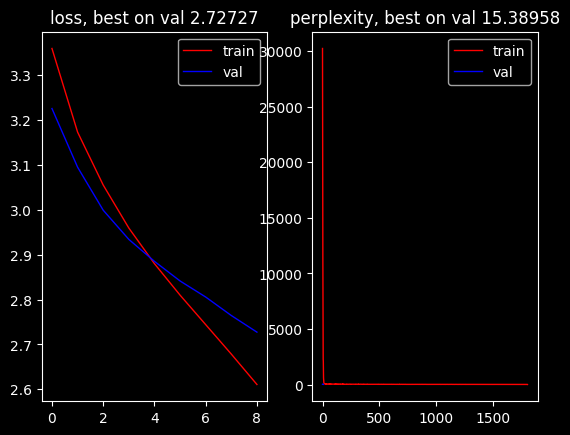

Language Model Linear с 2 GRU слоями


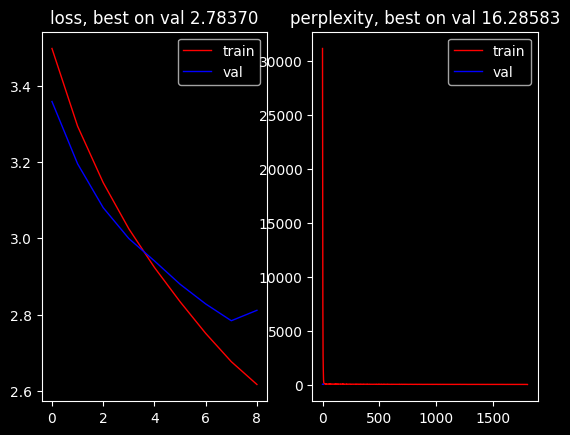

Language Model Linear с 2 Bidirectional GRU слоями


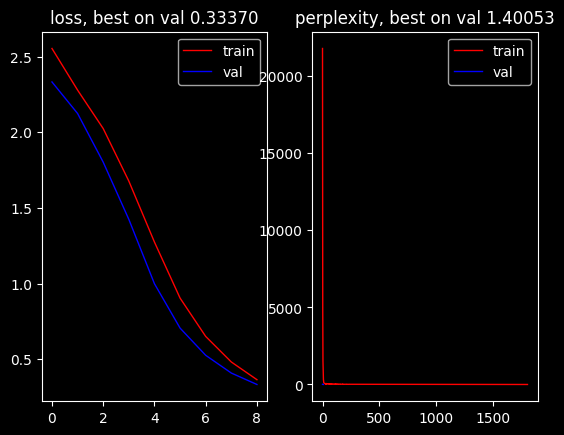

Language Model Conv Before GRU


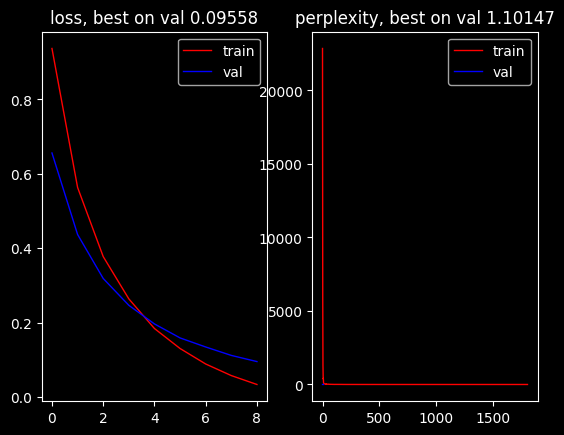

Language Model Conv Before GRU с батч нормализацией


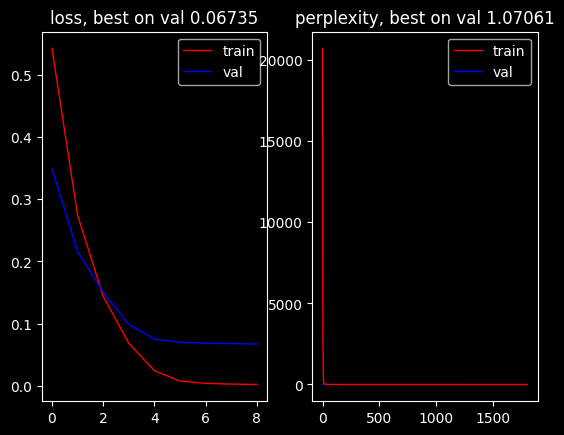

In [99]:
plot_result(history1, 'Language Model Linear с 1 GRU слоем')
plot_result(history2, 'Language Model Linear с 2 GRU слоями')
plot_result(history3, 'Language Model Linear с 2 Bidirectional GRU слоями')
plot_result(history4, 'Language Model Conv Before GRU')
plot_result(history5, 'Language Model Conv Before GRU с батч нормализацией')

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей. 

In [104]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 8) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(word, word2ind['<unk>']) for word in word_tokenize(starting_seq)]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_word_distribution = model(input_ids)[-1]
            next_word = next_word_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])

            if next_word.item() == word2ind['<eos>']:
                break
    
    words = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return words

generate_sequence(model, starting_seq='should we')

'<bos> should we crew lazy descent maidens novel mouth viewer able'